In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
print('pymc version:', pm.__version__)

RANDOM_SEED = 598

pymc version: 4.4.0


In [2]:
# create some gamma distributed data
# parameters for 4 gammma distributions, drawn from a distribution to simulate hierarchy
rng = np.random.default_rng(seed=RANDOM_SEED)
gamshapes = rng.normal(loc=15, scale=5, size=4)
gamscales = rng.exponential(scale=1, size=4)
print(f'gamma parameters: \nshapes {gamshapes}, \nscales {gamscales}')

gamma parameters: 
shapes [ 9.27177887 21.40387374 16.62925421  8.22314131], 
scales [0.18805205 0.0487087  0.38727134 0.48865624]


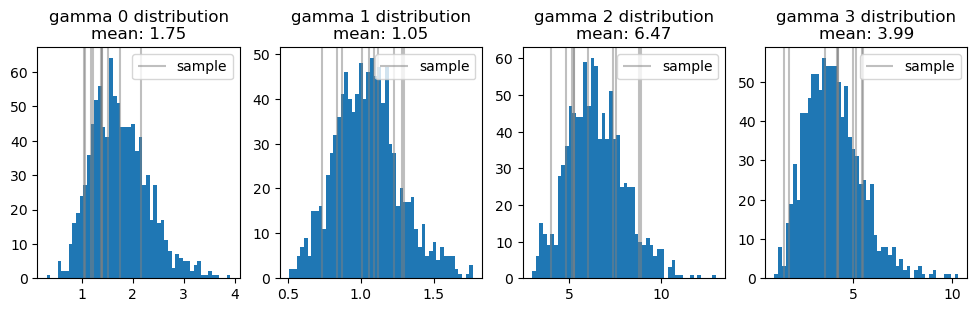

In [3]:
# plot distributions created with parameters
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
datadict = {}
for i, param in enumerate(zip(gamshapes, gamscales)):
    sample = rng.gamma(shape=param[0], scale=param[1], size=1000)
    axs[i].hist(sample, bins = 50)
    axs[i].set_title(f'gamma {i} distribution\nmean: {np.mean(sample).round(2)}')
    
    # get some small data samples from distributions
    datadict[f'group {i}'] = np.random.gamma(shape=param[0], scale=param[1], size=10)
    # plot small sample 
    axs[i].vlines(x=datadict[f'group {i}'], ymin=0, ymax=1, 
                  transform=axs[i].get_xaxis_transform(), color='gray', alpha=0.5, label='sample')
    axs[i].legend()

In [4]:
# put sample data into dataframe
df = pd.DataFrame(datadict)
print('shape:', df.shape)
df.head()

shape: (10, 4)


,group 0,group 1,group 2,group 3
0,1.075721,1.087321,5.273634,5.465015
1,2.156429,0.735454,8.910627,5.480388
2,1.040895,1.056038,3.991792,5.008121
3,1.399344,1.115008,7.354016,4.197773
4,1.216017,1.228128,4.821409,5.145574


In [5]:
# reshape data and relabel columns 
ydatadf = df.stack(level=0).reset_index().drop('level_0', axis=1)
ydatadf.columns = ['group', 'ydata']
ydatadf = ydatadf.sort_values(by=['group']).reset_index(drop=True)

In [6]:
ydatadf.head()

,group,ydata
0,group 0,1.075721
1,group 0,1.180565
2,group 0,2.156429
3,group 0,1.216017
4,group 0,1.409408


In [7]:
# variables to feed model
groupnum, groups = pd.factorize(ydatadf['group'])
ydata = ydatadf['ydata']

model without hierarchical structure, group means determined independently

In [8]:
# model without hierarchical structure
with pm.Model(coords={'groups':groups}) as gamma_model:

    # priors
    sigma = pm.Exponential('sigma', lam=1)
    # truncated normal keeps gamma parameters positive
    ai = pm.TruncatedNormal('ai', mu=0, sigma=0.2, lower=0.00001, dims='groups')
    
    # convert to original scale
    ai_convert = pm.Deterministic('ai_convert', 1 / ai, dims='groups')
    
    # use inverse link function to link means with gamma distributed data 
    y_est = 1 / (ai[groupnum])
    
    # reparameterize alpha and beta in terms of mean (y_est) and sigma
    alpha = y_est**2 / sigma**2 
    beta = y_est / sigma**2 
    
    # y data is gamma distributed
    y = pm.Gamma('y', alpha=alpha, beta=beta, observed=ydata)

In [9]:
with gamma_model:
    # sample prior predictive
    priorp = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [ai, sigma, y]


Text(0.5, 1.0, 'prior predictive distribution')

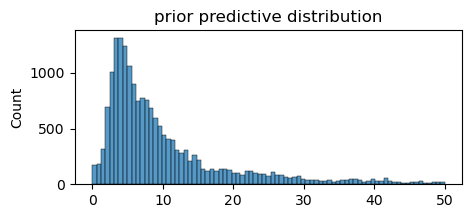

In [10]:
# check priors
# predicted outcome values under 'starting' priors, allows for a range of possible values
plt.figure(figsize=(5,2))
priorp_y = np.array(priorp.prior_predictive['y'])[:,:,:].flatten()
sns.histplot(x=priorp_y, binrange=(0,50))
plt.title('prior predictive distribution')

In [11]:
# sample to estimate parameters
with gamma_model:
    trace = pm.sample(draws=2000, tune=5000, random_seed=RANDOM_SEED, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, ai]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 43 seconds.


array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'ai'}>,
        <AxesSubplot:title={'center':'ai'}>],
       [<AxesSubplot:title={'center':'ai_convert'}>,
        <AxesSubplot:title={'center':'ai_convert'}>]], dtype=object)

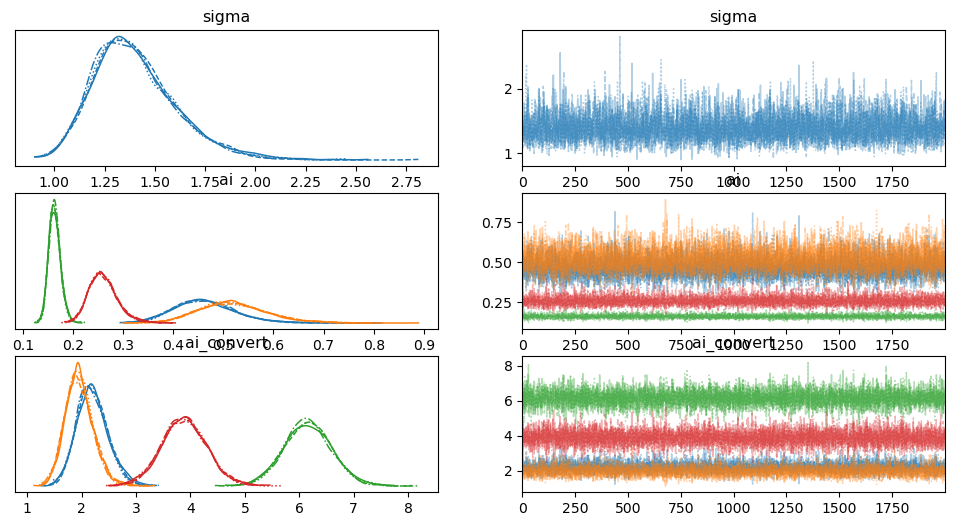

In [12]:
# check sampling:
# traces from different chains overlapping, sampling random
az.plot_trace(trace)
# az.plot_trace(trace, var_names=['mu_ai', 'sigma_ai', 'sigma', 'ai_convert'])

In [13]:
# check sampling: 
# effective sampling size (ess) large compared to number or samples taken
# r_hat, ratio of between chain variance and within chain variance, should be very close to 1.0
az.summary(trace)
# az.summary(trace, var_names=['mu_ai', 'sigma_ai', 'sigma', 'ai_convert'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.400,0.207,1.036,1.788,0.003,0.002,5238.0,4965.0,1.0
ai[group 0],0.463,0.060,0.353,0.578,0.001,0.001,6602.0,5345.0,1.0
ai[group 1],0.519,0.068,0.399,0.653,0.001,0.001,5831.0,5299.0,1.0
ai[group 2],0.163,0.012,0.142,0.185,0.000,0.000,6526.0,5291.0,1.0
ai[group 3],0.260,0.029,0.210,0.317,0.000,0.000,6107.0,4285.0,1.0
ai_convert[group 0],2.197,0.285,1.680,2.742,0.004,0.003,6602.0,5345.0,1.0
ai_convert[group 1],1.959,0.259,1.492,2.449,0.003,0.002,5831.0,5299.0,1.0
ai_convert[group 2],6.159,0.439,5.311,6.951,0.005,0.004,6526.0,5291.0,1.0
ai_convert[group 3],3.886,0.416,3.102,4.684,0.005,0.004,6107.0,4285.0,1.0


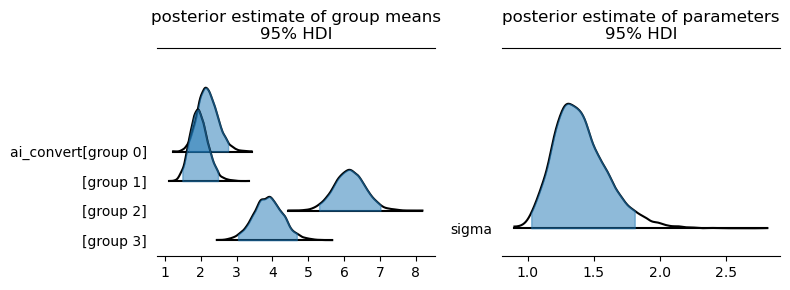

In [14]:
# plot posteriors
fig, ax = plt.subplots(1, 2, figsize=(8,3))
az.plot_forest(trace, kind='ridgeplot', var_names=['ai_convert'], combined=True, 
               ridgeplot_truncate=False, ridgeplot_alpha=0.5, hdi_prob=0.95, ax=ax[0])
ax[0].set_title('posterior estimate of group means\n95% HDI')
ax[0].locator_params(axis='x', nbins=10)

az.plot_forest(trace, kind='ridgeplot', var_names=['sigma'], combined=True, 
               ridgeplot_truncate=False, ridgeplot_alpha=0.5, hdi_prob=0.95, ax=ax[1])
ax[1].set_title('posterior estimate of parameters\n95% HDI')

fig.tight_layout()

model with hierarchical structure, groups assumed to be different, but have some relationship

In [15]:
with pm.Model(coords={'groups':groups}) as hierarchicalgamma_model:
    # global priors
    mu_ai = pm.Normal('mu_ai', mu=0, sigma=0.01)
    sigma_ai = pm.Exponential('sigma_ai', lam=10)
    
    # priors
    sigma = pm.Exponential('sigma', lam=1)
    # truncated normal keeps gamma parameters positive
    ai = pm.TruncatedNormal('ai', mu=mu_ai, sigma=sigma_ai, lower=0.00001, dims='groups')
    
    # convert to original scale
    ai_convert = pm.Deterministic('ai_convert', 1 / ai, dims='groups')
    
    # use inverse link function to link means with gamma distributed data 
    y_est = 1 / (ai[groupnum])
    
    # reparameterize alpha and beta in terms of mean (y_est) and sigma
    alpha = y_est**2 / sigma**2 
    beta = y_est / sigma**2 
    
    # y data is gamma distributed
    y = pm.Gamma('y', alpha=alpha, beta=beta, observed=ydata)

In [16]:
with hierarchicalgamma_model:
    # sample prior predictive
    priorp = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

Sampling: [ai, mu_ai, sigma, sigma_ai, y]


Text(0.5, 1.0, 'prior predictive distribution')

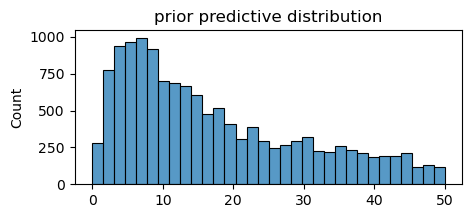

In [17]:
# check priors
# predicted outcome values under 'starting' priors, allows for a range of possible values
plt.figure(figsize=(5,2))
priorp_y = np.array(priorp.prior_predictive['y'])[:,:,:].flatten()
sns.histplot(x=priorp_y, binrange=(0,50))
plt.title('prior predictive distribution')

In [18]:
# sample to estimate parameters
with hierarchicalgamma_model:
    trace = pm.sample(draws=2000, tune=5000, random_seed=RANDOM_SEED, target_accept=0.85)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_ai, sigma_ai, sigma, ai]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 55 seconds.


array([[<AxesSubplot:title={'center':'mu_ai'}>,
        <AxesSubplot:title={'center':'mu_ai'}>],
       [<AxesSubplot:title={'center':'sigma_ai'}>,
        <AxesSubplot:title={'center':'sigma_ai'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'ai_convert'}>,
        <AxesSubplot:title={'center':'ai_convert'}>]], dtype=object)

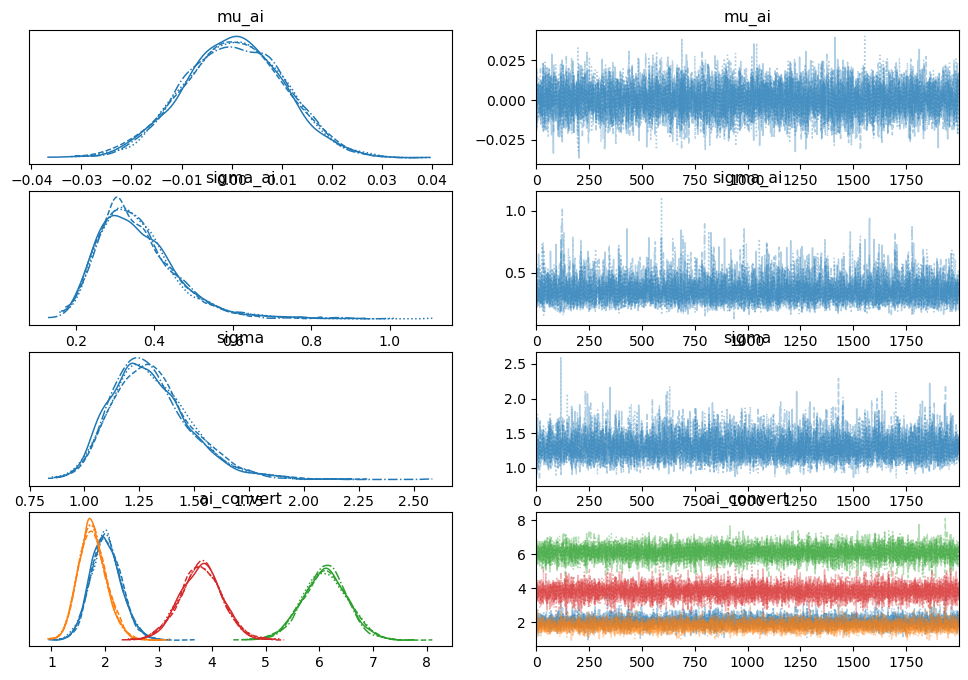

In [19]:
# check sampling:
# traces from different chains overlapping, sampling random
# az.plot_trace(trace)
az.plot_trace(trace, var_names=['mu_ai', 'sigma_ai', 'sigma', 'ai_convert'])

In [20]:
# check sampling: 
# effective sampling size (ess) large compared to number or samples taken
# r_hat, ratio of between chain variance and within chain variance, should be very close to 1.0
# az.summary(trace)
az.summary(trace, var_names=['mu_ai', 'sigma_ai', 'sigma', 'ai_convert'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_ai,0.000,0.010,-0.017,0.020,0.000,0.000,10736.0,5829.0,1.0
sigma_ai,0.357,0.100,0.199,0.544,0.001,0.001,9328.0,6008.0,1.0
sigma,1.305,0.180,0.994,1.642,0.002,0.002,7278.0,6351.0,1.0
ai_convert[group 0],2.020,0.287,1.472,2.549,0.003,0.002,7935.0,5922.0,1.0
ai_convert[group 1],1.767,0.263,1.294,2.274,0.003,0.002,8203.0,6480.0,1.0
ai_convert[group 2],6.102,0.422,5.306,6.893,0.004,0.003,9406.0,5567.0,1.0
ai_convert[group 3],3.791,0.398,3.043,4.547,0.004,0.003,9464.0,6191.0,1.0


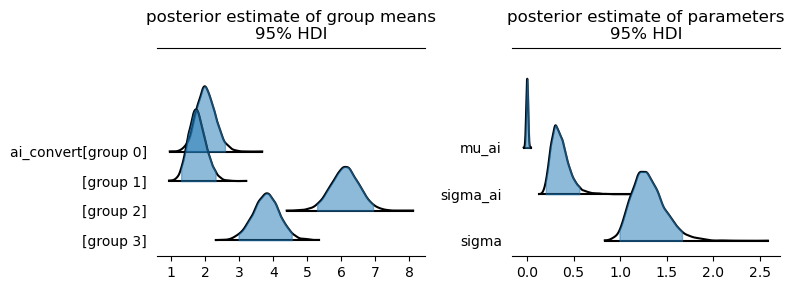

In [21]:
# plot posteriors
fig, ax = plt.subplots(1, 2, figsize=(8,3))
az.plot_forest(trace, kind='ridgeplot', var_names=['ai_convert'], combined=True, 
               ridgeplot_truncate=False, ridgeplot_alpha=0.5, hdi_prob=0.95, ax=ax[0])
ax[0].set_title('posterior estimate of group means\n95% HDI')
ax[0].locator_params(axis='x', nbins=10)

az.plot_forest(trace, kind='ridgeplot', var_names=['mu_ai', 'sigma_ai', 'sigma'], combined=True, 
               ridgeplot_truncate=False, ridgeplot_alpha=0.5, hdi_prob=0.95, ax=ax[1])
ax[1].set_title('posterior estimate of parameters\n95% HDI')

fig.tight_layout()

Both models capture the means of groups 0, 2, and 3 (1.75, 6.47, and 3.99) in their 95% HDI estimates of the means. Group 1 was harder, with both models' 95% HDI estimates of the mean higher than the calculated mean (1.05) after 1000 random draws from the distribution. Possibly due to the partial pooling of information from the hierarchical structure, the mean estimates of the hierarchical model are a bit closer to the calculated means than the unpooled/non-hierarchical model.